In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from pathlib import Path

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

from fastai import *          # Quick access to most common functionality
from fastai.tabular import *  # Quick access to tabular functionality

In [2]:
path = Path('data/canais/')
path

PosixPath('data/canais')

In [3]:
files = [x for x in path.glob('*2018.csv') if x.is_file()]

In [4]:
files

[PosixPath('data/canais/canais012018.csv'),
 PosixPath('data/canais/canais022018.csv'),
 PosixPath('data/canais/canais062018.csv'),
 PosixPath('data/canais/canais082018.csv'),
 PosixPath('data/canais/canais032018.csv'),
 PosixPath('data/canais/canais042018.csv'),
 PosixPath('data/canais/canais052018.csv'),
 PosixPath('data/canais/canais072018.csv'),
 PosixPath('data/canais/canais092018.csv')]

In [5]:
files_df = []

In [6]:
columns = ['date', 'hour', 'servico', 'modulo', 'qtd_erro', 'qtd_registro', 'tempo_medio', '', '','','']

In [7]:
for file in sorted(files):
    df =  pd.read_csv(file, sep='\t', skiprows=1, names=columns, encoding='utf-16')
    df = df.drop(df.columns[[7, 8, 9, 10]], axis=1)
    files_df.append(df)

/home/marco/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/io/parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
/home/marco/anaconda3/envs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
len(files_df)

9

In [9]:
df = pd.concat(files_df)
df.tail()

,date,hour,servico,modulo,qtd_erro,qtd_registro,tempo_medio
181112,2018-09-10,13,OBTFAV,SICOOBNET CELULAR,0,1644,"41,06995134"
181113,2018-09-10,18,OBTERINFORMACOESCLO,SICOOBNET EMPRESARIAL,0,707,"248,74115983"
181114,2018-09-10,11,OBTDT,CAIXA,0,8027,"13,19509157"
181115,2018-09-10,10,OBTDT,CAIXA,1,8371,"14,02819257"
181116,2018-09-30,11,REGVER,CAIXA,0,8,"6,75"


In [10]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [11]:
# Concatenar data e hora (int) em uma coluna datetime
df.date = pd.to_datetime(df.date)
df.hour = pd.to_timedelta(df.hour, unit='h')
df['datetime'] = df.date + df.hour

# Aplicar função add_datepart para criar features relacionadas
add_datepart(df, 'datetime', drop=True, time=True)

# Remover as colunas date, hour, qtd_erro, qtd_registro
df = df.drop(df.columns[[0, 1, 4, 5]], axis=1)

# Converter tempo_medio para float32 (formato esperado pelo pytorch)
df['tempo_medio'] = df['tempo_medio'].str.replace(',','.').astype(np.float32)

In [12]:
df = df.loc[df['servico'] == 'ACESSOFUNCINTERNET']

In [13]:
df = df.loc[df['tempo_medio'] < 300.0]

In [14]:
mean_col = df.groupby(['servico', 'datetimeDayofweek', 'datetimeHour'])['tempo_medio'].mean() # don't reset the index!
df = df.set_index(['servico', 'datetimeDayofweek', 'datetimeHour']) # make the same index here
df['tempo_medio_mean'] = mean_col
df = df.reset_index()

In [15]:
median_col = df.groupby(['servico', 'datetimeDayofweek', 'datetimeHour'])['tempo_medio'].median() # don't reset the index!
df = df.set_index(['servico', 'datetimeDayofweek', 'datetimeHour']) # make the same index here
df['tempo_medio_median'] = median_col
df = df.reset_index()

In [16]:
df.tail()

,servico,datetimeDayofweek,datetimeHour,modulo,tempo_medio,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofyear,...,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeMinute,datetimeSecond,datetimeElapsed,tempo_medio_mean,tempo_medio_median
20217,ACESSOFUNCINTERNET,1,9,SICOOBNET EMPRESARIAL,149.638885,2018,9,37,11,254,...,False,False,False,False,False,0,0,1536656400,114.066956,104.219269
20218,ACESSOFUNCINTERNET,2,21,SICOOBNET EMPRESARIAL,104.333336,2018,9,37,12,255,...,False,False,False,False,False,0,0,1536786000,81.598099,73.506462
20219,ACESSOFUNCINTERNET,2,15,SICOOBNET CELULAR,104.369011,2018,9,37,12,255,...,False,False,False,False,False,0,0,1536764400,113.562637,106.082451
20220,ACESSOFUNCINTERNET,1,0,SICOOBNET EMPRESARIAL,93.000000,2018,9,37,11,254,...,False,False,False,False,False,0,0,1536624000,90.163765,82.982506
20221,ACESSOFUNCINTERNET,1,20,PORTAL,73.129768,2018,9,37,11,254,...,False,False,False,False,False,0,0,1536696000,80.267464,74.111115


In [17]:
dep_var = 'tempo_medio'
cat_names = ['servico', 'modulo', 'datetimeYear', 'datetimeMonth', 'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 
            'datetimeDayofyear', 'datetimeIs_month_end', 'datetimeIs_month_start', 'datetimeIs_quarter_end', 
            'datetimeIs_quarter_start', 'datetimeIs_year_end', 'datetimeIs_year_start', 'datetimeHour', 'datetimeMinute', 
            'datetimeSecond']

In [123]:
# for v in cat_names: df[v] = df[v].astype('category').cat.as_ordered()

In [18]:
train_df = df[:20000]
valid_df = df[20000:]

In [504]:
train_df = df[:141115]
valid_df = df[141115:]

In [19]:
data = TabularDataBunch.from_df(path, train_df, valid_df, dep_var, tfms=[Categorify], cat_names=cat_names)

/home/marco/anaconda3/envs/ml/lib/python3.6/site-packages/fastai/tabular/transform.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = df[n].astype('category').cat.as_ordered()
/home/marco/anaconda3/envs/ml/lib/python3.6/site-packages/fastai/tabular/transform.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(df[n], categories=self.categories[n], ordered=True)


In [20]:
learn = get_tabular_learner(data, layers=[200,100], metrics=accuracy)

In [ ]:
learn.fit(1, 1e-2)

In [506]:
cats_train,conts_train = data.train_ds.cats.numpy(), data.train_ds.conts.numpy()

In [507]:
x_train = np.concatenate((cats_train,conts_train), axis=1)
x.shape

(141115, 20)

In [508]:
y_train = data.train_ds.y.numpy()

In [509]:
cats_valid,conts_valid = data.valid_ds.cats.numpy(), data.valid_ds.conts.numpy()

In [510]:
x_valid = np.concatenate((cats_valid,conts_valid), axis=1)
x.shape

(141115, 20)

In [511]:
y_valid = data.valid_ds.y.numpy()

In [512]:
model = LGBMRegressor()

In [513]:
model.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [514]:
model.score(x_train, y_train)

0.8923144972565257

In [515]:
model.score(x_valid, y_valid)

0.8096946134310196

In [474]:
y_pred = model.predict(x_valid)

In [475]:
model.feature_importances_

array([  0, 273,   0,  64, 203, 429, 150, 495,   5,   0,   0,   3,   0,
         7, 272,   0,   0, 365, 436, 298])

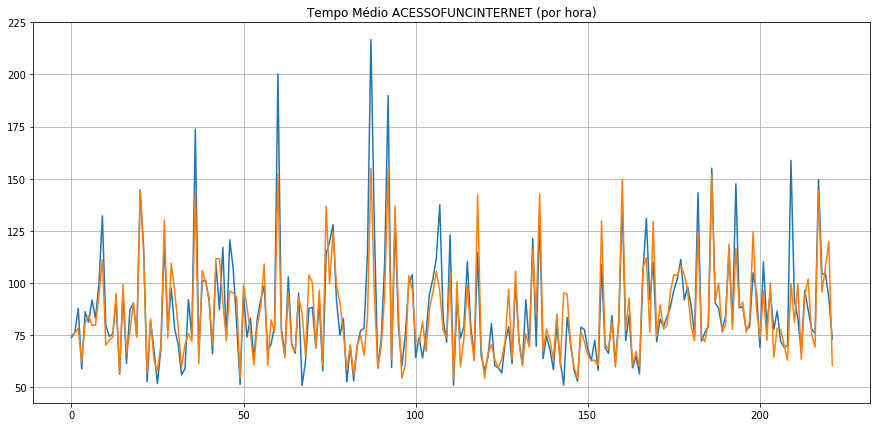

In [487]:
plt.figure(figsize=(15, 7))
plt.plot(y_valid[:])
plt.plot(y_pred[:])
plt.title('Tempo Médio ACESSOFUNCINTERNET (por hora)')
plt.grid(True)
plt.show()

In [477]:
model = XGBRegressor()

In [478]:
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [479]:
model.score(x_train, y_train)

0.6047540356659995

In [480]:
model.score(x_valid, y_valid)

0.7659139251839155

In [481]:
y_pred = model.predict(x_valid)

In [482]:
model.feature_importances_

array([0.        , 0.19308357, 0.        , 0.00720461, 0.03602305,
       0.08933718, 0.04322767, 0.04034582, 0.00432277, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02881844,
       0.        , 0.        , 0.34005764, 0.15561959, 0.06195965],
      dtype=float32)

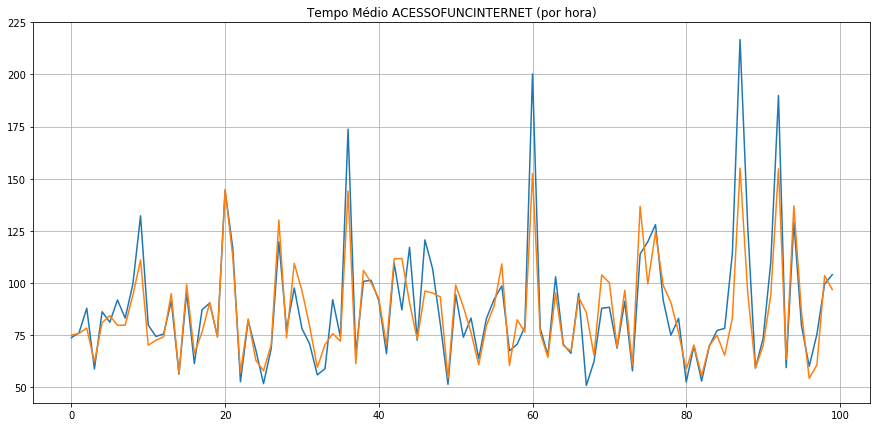

In [483]:
plt.figure(figsize=(15, 7))
plt.plot(y_valid[:100])
plt.plot(y_pred[:100])
plt.title('Tempo Médio ACESSOFUNCINTERNET (por hora)')
plt.grid(True)
plt.show()

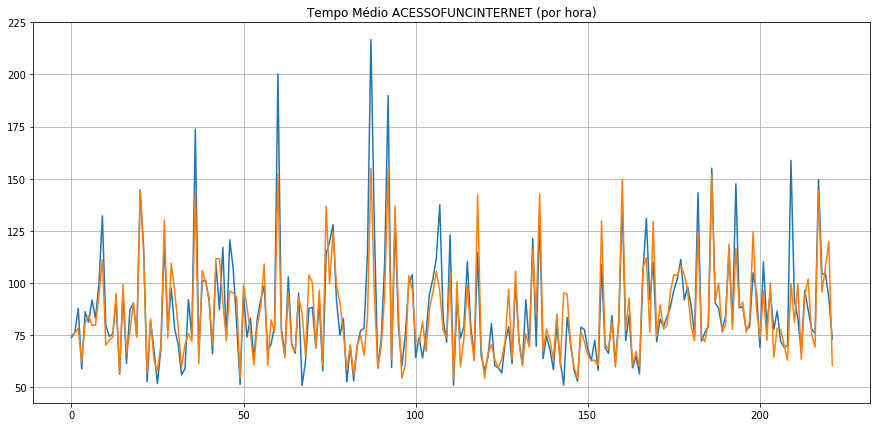

In [495]:
plt.figure(figsize=(15, 7))
plt.plot(valid_df.reset_index().tempo_medio)
plt.plot(y_pred)
plt.title('Tempo Médio ACESSOFUNCINTERNET (por hora)')
plt.grid(True)
plt.show()

In [428]:
y_valid

array([27.184942 , 62.64706  , 12.721399 , ..., 13.195091 , 14.0281925,
        6.75     ], dtype=float32)

In [ ]:
data.train_dl.c

In [ ]:
data.valid_dl

In [402]:
t = next(iter(data.train_dl))
len(t[0]), len(t[0][0]), len(t[0][0][0]), len(t[0][1][0]), len(t[1])

(2, 64, 17, 3, 64)

In [403]:
v = next(iter(data.valid_dl))
len(v[0]), len(v[0][0]), len(v[0][0][0]), len(v[0][1][0]), len(v[1])

(2, 128, 17, 3, 128)

In [50]:
learn = get_tabular_learner(data, layers=[200,100], metrics=accuracy)

In [ ]:
learn.model

In [ ]:
learn.fit(1, 1e-2)

In [ ]:
%debug

In [28]:
learn.loss_func

<function torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='elementwise_mean')>

In [83]:
learn.loss_func = torch.nn.functional.cross_entropy

In [164]:
learn.

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

In [ ]:
x_train, x_test = train_df.drop(['tempo_medio'], axis=1), valid_df.drop(['tempo_medio'], axis=1)
y_train, y_test = train_df['tempo_medio'].values, valid_df['tempo_medio'].values

In [ ]:
ads = pd.read_csv('../../data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('../../data/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [277]:
df_test = df.loc[(df['servico'] == 'ACESSOFUNCINTERNET') & (df['datetime'] >= '2018-09-01')]

In [263]:
df_test = df.loc[df['servico'] == 'ACESSOFUNCINTERNET']

In [228]:
df_test.dtypes

servico                             object
modulo                              object
tempo_medio                        float32
datetime                    datetime64[ns]
datetimeYear                         int64
datetimeMonth                        int64
datetimeWeek                         int64
datetimeDay                          int64
datetimeDayofweek                    int64
datetimeDayofyear                    int64
datetimeIs_month_end                  bool
datetimeIs_month_start                bool
datetimeIs_quarter_end                bool
datetimeIs_quarter_start              bool
datetimeIs_year_end                   bool
datetimeIs_year_start                 bool
datetimeHour                         int64
datetimeMinute                       int64
datetimeSecond                       int64
datetimeElapsed                      int64
dtype: object

In [278]:
df_test.tempo_medio.max(), df_test.tempo_medio.mean(), df_test.tempo_medio.median() 

(5901.0, 96.32517, 79.42727)

In [279]:
df_test.loc[df_test['tempo_medio'] > 800.0, 'tempo_medio'] = 800.

In [302]:
df.loc[df['tempo_medio'] > 800.0, 'tempo_medio'] = 800.

In [280]:
df_test.tempo_medio.max(), df_test.tempo_medio.mean(), df_test.tempo_medio.median() 

(800.0, 89.71375, 79.42727)

In [281]:
# df_test.set_index('datetime', inplace=True)


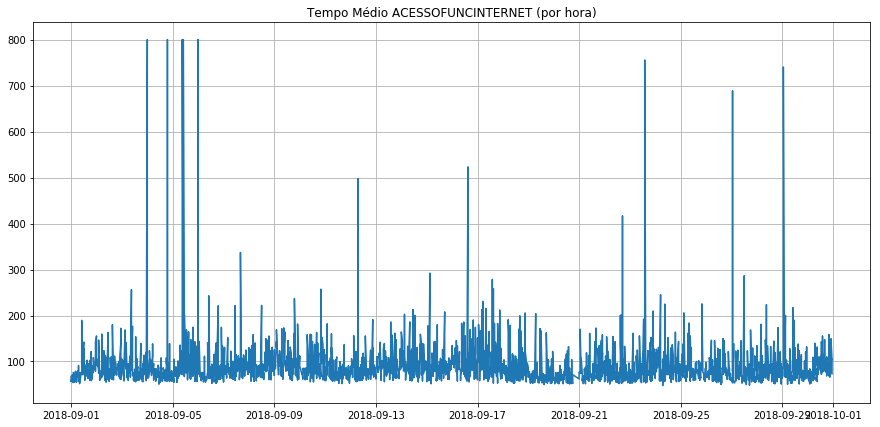

In [282]:
plt.figure(figsize=(15, 7))
plt.plot(df_test.sort_values(by=['datetime']).datetime, df_test.tempo_medio)
plt.title('Tempo Médio ACESSOFUNCINTERNET (por hora)')
plt.grid(True)
plt.show()

In [23]:
# from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics

In [135]:
data.train_ds.conts.shape, data.train_ds.cats.shape

(torch.Size([141115, 1]), torch.Size([141115, 17]))

In [305]:
cats,conts = data.train_ds.cats.numpy(), data.train_ds.conts.numpy()

In [306]:
x = np.concatenate((cats, conts), axis=1)

In [307]:
x.shape

(141115, 18)

In [308]:
y = data.train_ds.y.numpy()

In [140]:
m = RandomForestClassifier(n_jobs=-1)

In [ ]:
m.fit(x, y)
m.score(x,y)

In [84]:
from sklearn.linear_model import SGDRegressor

In [142]:
m = SGDRegressor()

In [143]:
m.fit(x, y)

/home/marco/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [144]:
m.score(x,y)

-7278039418234.614

In [318]:
df_test = data.valid_dl.

AttributeError: 'DataLoader' object has no attribute 'numpy'

In [146]:
df_test = np.concatenate((cats_test,conts_test), axis=1)

NameError: name 'cats_test' is not defined

In [48]:
df.modulo.unique()

array(['SICOOBNET CELULAR EMPRESARIAL', 'SICOOBNET CELULAR',
       'SICOOBNET PESSOAL', 'SICOOB ATM', 'SICOOBNET EMPRESARIAL',
       'CORRESPONDENTE BANCÁRIO', 'CEDENTE', 'SICOOB NÃO CORRENTISTA',
       'CAIXA', 'PORTAL', 'SICOOB FONE', 'CREDICOM - VIP SERVICE',
       'SICOOB FACEBOOK', 'RETAGUARDA', 'PROCESSAMENTO OFFICE CNAB',
       'SICOOBNET NAO CORRENTISTA CELULAR'], dtype=object)

In [12]:
df_teste =  pd.read_csv(path/'teste.csv', sep='\t', skiprows=1, names=columns, encoding='utf-16')
df_teste = df_teste.drop(df_teste.columns[[7, 8, 9, 10]], axis=1)
df_teste.head()

/home/marco/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/io/parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,data,hora,serviço,modulo,qtd erro,qtd rgistro,tempo médio
0,2018-01-01,8,ACESSOFUNCINTERNET,SICOOBNET CELULAR EMPRESARIAL,0,2,"84,5"
1,2018-01-01,8,ACESSOFUNCINTERNET,SICOOBNET CELULAR,0,3803,"77,08177754"
2,2018-01-01,17,AGENDATED,SICOOBNET CELULAR EMPRESARIAL,0,21,"477,66666667"
3,2018-01-01,12,ACESSOFUNCINTERNET,SICOOBNET CELULAR,0,7900,"67,8964557"
4,2018-01-01,12,ACESSOFUNCINTERNET,SICOOBNET CELULAR EMPRESARIAL,0,8,"69,25"


In [14]:
df_teste.data = pd.to_datetime(df_teste.data)

In [15]:
df_teste.hora = pd.to_timedelta(df_teste.hora, unit='h')

In [16]:
df_teste.dtypes

data            datetime64[ns]
hora           timedelta64[ns]
serviço                 object
modulo                  object
qtd erro                 int64
qtd rgistro              int64
tempo médio             object
dtype: object

In [30]:
df_teste.loc[df_teste['serviço'] == 'ACESSOFUNCINTERNET']

,data,hora,serviço,modulo,qtd erro,qtd rgistro,tempo médio,datetime,datetimeYear,datetimeMonth,...,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeElapsed
0,2018-01-01,08:00:00,ACESSOFUNCINTERNET,SICOOBNET CELULAR EMPRESARIAL,0,2,"84,5",2018-01-01 08:00:00,2018,1,...,1,0,1,False,True,False,True,False,True,1514793600
1,2018-01-01,08:00:00,ACESSOFUNCINTERNET,SICOOBNET CELULAR,0,3803,"77,08177754",2018-01-01 08:00:00,2018,1,...,1,0,1,False,True,False,True,False,True,1514793600
3,2018-01-01,12:00:00,ACESSOFUNCINTERNET,SICOOBNET CELULAR,0,7900,"67,8964557",2018-01-01 12:00:00,2018,1,...,1,0,1,False,True,False,True,False,True,1514808000
4,2018-01-01,12:00:00,ACESSOFUNCINTERNET,SICOOBNET CELULAR EMPRESARIAL,0,8,"69,25",2018-01-01 12:00:00,2018,1,...,1,0,1,False,True,False,True,False,True,1514808000
7,2018-01-01,11:00:00,ACESSOFUNCINTERNET,SICOOBNET CELULAR EMPRESARIAL,0,13,"63,15384615",2018-01-01 11:00:00,2018,1,...,1,0,1,False,True,False,True,False,True,1514804400
11,2018-01-01,20:00:00,ACESSOFUNCINTERNET,SICOOBNET CELULAR,0,12409,"70,61133049",2018-01-01 20:00:00,2018,1,...,1,0,1,False,True,False,True,False,True,1514836800
14,2018-01-01,10:00:00,ACESSOFUNCINTERNET,SICOOBNET EMPRESARIAL,0,40,"110,725",2018-01-01 10:00:00,2018,1,...,1,0,1,False,True,False,True,False,True,1514800800


In [ ]:


dep_var = '>=50k'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
data = TabularDataBunch.from_df(path, train_df, valid_df, dep_var, 
                                tfms=[FillMissing, Categorify], cat_names=cat_names)



In [518]:
!pip install --trusted-host=pypi.python.org --trusted-host=pypi.org --trusted-host=files.pythonhosted.orginstall pystan

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLError("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",),)': /packages/49/f9/106f3db81cf4da1be937a11b63f400d072718662f3fd1349ea7f0458aa0f/pystan-2.18.0.0-cp36-cp36m-manylinux1_x86_64.whl
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLError("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",),)': /packages/49/f9/106f3db81cf4da1be937a11b63f400d072718662f3fd1349ea7f0458aa0f/pystan-2.18.0.0-cp36-cp36m-manylinux1_x86_64.whl
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLError("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",),)': /packages/49/f9/106f3db81cf4da1be937a